# Estimating a function using Neural Networks

Let's assume we want to train a model that can estimate the function.
$$f(x,y) = x^2 - y^2$$

If running this in Colab, first set your runtime type to GPU.

In [88]:
!pip install -q ipympl

In [89]:
from google.colab import output
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode in Google Colab
%matplotlib widget

output.enable_custom_widget_manager()

## ⛱️Visualization of function

In [90]:
def f(x, y):
    return x**2 - y**2

x = np.linspace(-5, 5, 1000)
y = np.linspace(-5, 5, 1000)
z = f(x, y)
x_grid, y_grid = np.meshgrid(x, y)
z_grid = f(x_grid, y_grid)

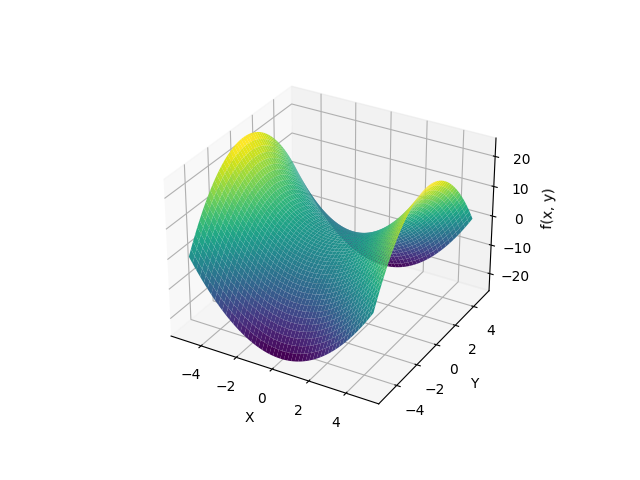

In [91]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(x, y)')

plt.show()

## 🏜️What we have in real world
In real world that we don't have infinite number of data (i.e. `x` and `y`) with corresponding labels `z`. In image classification as example, you can consider the input as a large tensor `HxWxC` and the output `z` is the corresponding category label.

What we have instead is some sparse samples.

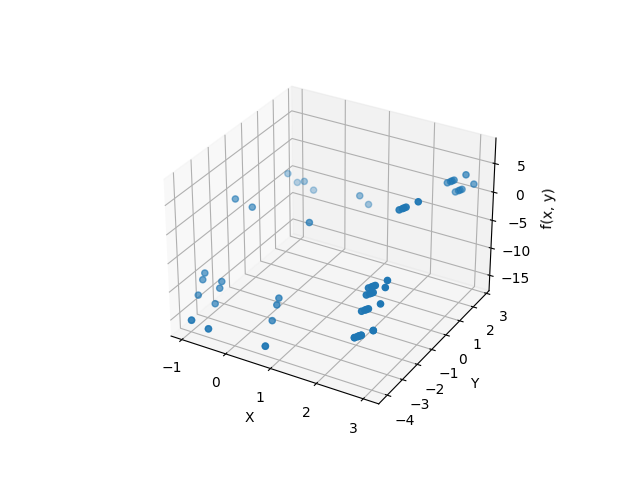

In [92]:
y = np.random.uniform(-5, 5, 8)
x = np.random.uniform(-5, 5, 8)
z = f(x, y)
x_grid, y_grid = np.meshgrid(x, y)
z_grid = f(x_grid, y_grid)


# Visualize
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x_grid, y_grid, z_grid)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(x, y)')

plt.show()

## 📂Writing a Dataset class in PyTorch

In [93]:
from torch.utils.data import Dataset

class MyCustomDataset(Dataset):
    def __init__(self, x, y, z):
        assert len(x) == len(y) == len(z)
        self.inputs = np.stack([x.flatten(), y.flatten()], axis=1).astype(np.float32)
        self.targets = z.flatten().astype(np.float32)

    def __getitem__(self, idx):
        model_input = self.inputs[idx]
        target = self.targets[idx]

        return model_input, target

    def __len__(self):
        return self.targets.shape[0]

In [94]:
dataset = MyCustomDataset(x_grid, y_grid, z_grid)

sample_in, sample_out = dataset[0]
print(f"Sample input: {sample_in}")
print(f"Sample output: {sample_out}")
print(f"Length of dataset: {len(dataset)}")

Sample input: [-0.95907235  2.7060084 ]
Sample output: -6.4026618003845215
Length of dataset: 64


### Dataloader

Pin Memory :
Host: Pageable Memory 可分页内存
Pinned Memory 页锁定内存

GPU device:
DRAM 动态随机存取存储器

In [95]:
from torch.utils.data import DataLoader

loader = DataLoader(dataset,
                    batch_size=8,
                    drop_last=False,
                    num_workers=0,
                    pin_memory=True,
                    shuffle=True,
                    )

In [96]:
batch_in, batch_out = next(iter(loader))
print(f"Batch input: {batch_in}")
print(f"Batch output: {batch_out}")

Batch input: tensor([[-0.5734, -3.1836],
        [-0.9591, -3.1836],
        [ 2.7842, -4.0549],
        [ 3.0333, -3.3161],
        [ 2.7435,  2.0862],
        [ 2.7102, -3.3161],
        [ 2.7435,  2.7060],
        [ 0.7109, -3.6103]])
Batch output: tensor([ -9.8063,  -9.2153,  -8.6903,  -1.7957,   3.1744,  -3.6514,   0.2042,
        -12.5286])


In [97]:
for batch_in, batch_out in loader:
    print(f"Batch input: {batch_in}")
    print(f"Batch output: {batch_out}")
    break

Batch input: tensor([[ 2.7435, -4.0515],
        [ 3.0333, -4.0515],
        [ 2.6420, -3.3161],
        [-0.9591, -4.0549],
        [-0.5734, -4.0549],
        [ 0.7109, -4.0549],
        [ 2.7842, -3.1836],
        [ 2.6420, -1.2436]])
Batch output: tensor([ -8.8881,  -7.2137,  -4.0165, -15.5224, -16.1135, -15.9368,  -2.3832,
          5.4338])


### Why `shuffle=True` is necessary?

Because not doing it increases the chance of overfitting. Based on order of which the data is sorted, in each batch of data it might see a wrong signal of the true form of function `f` to be estimated.

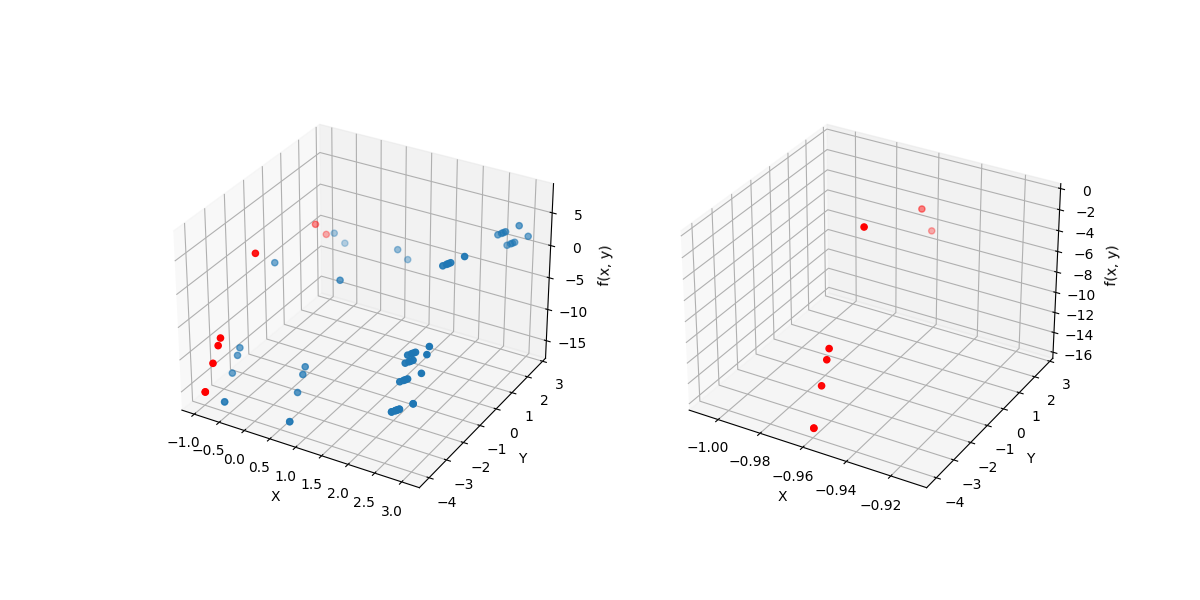

In [98]:
fig = plt.figure(figsize=(12, 6))
ax0 = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122, projection='3d')

ax0.scatter(x_grid[:, 1:], y_grid[:, 1:], z_grid[:, 1:])
ax0.scatter(x_grid[:, 0], y_grid[:, 0], z_grid[:, 0], color='red')
ax1.scatter(x_grid[:, 0], y_grid[:, 0], z_grid[:, 0], color='red')

ax0.set_xlabel('X')
ax0.set_ylabel('Y')
ax0.set_zlabel('f(x, y)')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('f(x, y)')

plt.show()

As an example from the visualization above, the minibatch might select points from the red scatters that:
- Can learn the function changes in Y axis.
- Has no clue how the function changes in X axis.


But by shuffling, each batch should see random points that better demonstrates how function changes with respect to the input.

## ⚙️ Train a linear model

In [99]:
import torch
from torch import nn, optim #nn is neural network
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # if cuda is unable to use, use CPU, this is a code for choosing the device we run the following code

model = nn.Linear(2, 1)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

print(f"Model: {model}", end='\n\n')
print(f"Model weight: {model.weight}", end='\n\n')
print(f"Model bias: {model.bias}", end='\n\n')

Model: Linear(in_features=2, out_features=1, bias=True)

Model weight: Parameter containing:
tensor([[-0.4168, -0.3425]], device='cuda:0', requires_grad=True)

Model bias: Parameter containing:
tensor([0.3954], device='cuda:0', requires_grad=True)



model = nn.Linear(2,1)

结果用了：$y = xW^T +b$
x -> (2,)
W -> (2,1)
b -> (1,)

In [100]:
n_epochs = 20 #Here it assigned epoch number
for epoch in range(n_epochs):
    epoch_loss = 0
    for sample, target in loader: # Using loop makes it run faster.
        sample, target = sample.to(device), target.to(device)

        optimizer.zero_grad()

        out = model(sample)
        loss = criterion(out.squeeze(), target) # (8,), target = (8,) meaning of out.squeeze.
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss / len(loader)}")

Epoch 1/20, Loss: 71.86578226089478
Epoch 2/20, Loss: 60.46802258491516
Epoch 3/20, Loss: 52.13678765296936
Epoch 4/20, Loss: 46.26832842826843
Epoch 5/20, Loss: 42.07204055786133
Epoch 6/20, Loss: 38.85155010223389
Epoch 7/20, Loss: 36.60081171989441
Epoch 8/20, Loss: 34.7417311668396
Epoch 9/20, Loss: 33.35374176502228
Epoch 10/20, Loss: 32.24334979057312
Epoch 11/20, Loss: 31.346607208251953
Epoch 12/20, Loss: 30.54458248615265
Epoch 13/20, Loss: 29.927173972129822
Epoch 14/20, Loss: 29.321055054664612
Epoch 15/20, Loss: 28.81213915348053
Epoch 16/20, Loss: 28.399201154708862
Epoch 17/20, Loss: 27.990431666374207
Epoch 18/20, Loss: 27.660792887210846
Epoch 19/20, Loss: 27.415851175785065
Epoch 20/20, Loss: 27.090139031410217


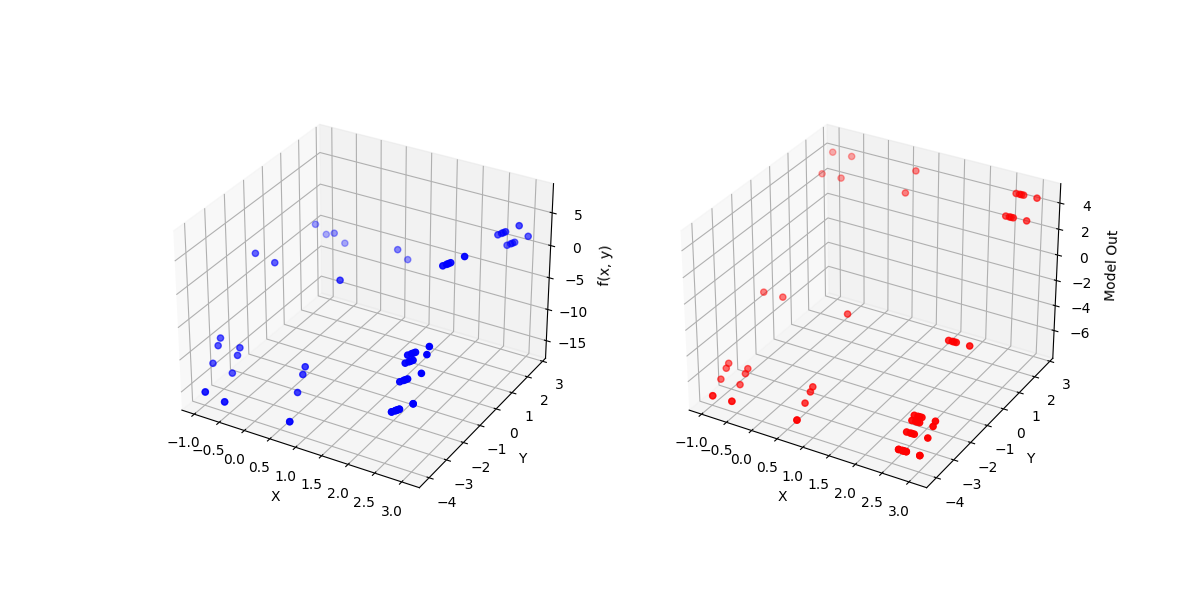

In [101]:
# Gather all Data
sample_x, sample_y, sample_z, sample_out = [], [], [], []
for sample, target in loader:
    sample, target = sample.to(device), target.to(device)
    out = model(sample)

    sample = sample.cpu().detach().numpy()
    target = target.cpu().detach().numpy()
    out = out.cpu().detach().numpy()

    sample_x.append(sample[:, 0])
    sample_y.append(sample[:, 1])
    sample_z.append(target)
    sample_out.append(out)

sample_x = np.concatenate(sample_x).reshape(8, 8)
sample_y = np.concatenate(sample_y).reshape(8, 8)
sample_z = np.concatenate(sample_z).reshape(8, 8)
sample_out = np.concatenate(sample_out).reshape(8, 8)

# Visualize
fig = plt.figure(figsize=(12, 6))
ax0 = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122, projection='3d')

ax0.scatter(sample_x, sample_y, sample_z, color='Blue')
ax1.scatter(sample_x, sample_y, sample_out, color='red')

ax0.set_xlabel('X')
ax0.set_ylabel('Y')
ax0.set_zlabel('f(x, y)')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Model Out')

plt.show()

## ⚙️ Train a neural network

**Approach 1 (nn.Module):**

In [102]:
class Network(nn.Module):
    def __init__(self, hidden_size=64):
        super().__init__()

        self.hidden = nn.Linear(2, hidden_size)
        self.output = nn.Linear(hidden_size, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)

        return x

model = Network()
model.to(device)
print(model)

for name, param in model.named_parameters():
  print(name, param.shape, param.requires_grad)

Network(
  (hidden): Linear(in_features=2, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)
hidden.weight torch.Size([64, 2]) True
hidden.bias torch.Size([64]) True
output.weight torch.Size([1, 64]) True
output.bias torch.Size([1]) True


 # Why inherit nn.Module
 ### Forcing us to use "forward" interface
model = Network()

model(x) # it calls forward
### automatically calculate gradient

**Approach 2 (nn.Sequential)**

In [103]:
model = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)
model.to(device)

print(model)
for name, param in model.named_parameters():
  print(name, param.shape)

Sequential(
  (0): Linear(in_features=2, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
)
0.weight torch.Size([64, 2])
0.bias torch.Size([64])
2.weight torch.Size([1, 64])
2.bias torch.Size([1])


**Training:**

In [104]:
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)

n_epochs = 20
for epoch in range(n_epochs):
    epoch_loss = 0
    for sample, target in loader:
        sample, target = sample.to(device), target.to(device)

        optimizer.zero_grad()

        out = model(sample)
        loss = criterion(out.squeeze(), target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss / len(loader)}")

Epoch 1/20, Loss: 40.728761196136475
Epoch 2/20, Loss: 26.256900310516357
Epoch 3/20, Loss: 20.623910069465637
Epoch 4/20, Loss: 17.43053126335144
Epoch 5/20, Loss: 15.090068876743317
Epoch 6/20, Loss: 13.207562386989594
Epoch 7/20, Loss: 11.559438616037369
Epoch 8/20, Loss: 10.299253940582275
Epoch 9/20, Loss: 9.311686515808105
Epoch 10/20, Loss: 8.53396162390709
Epoch 11/20, Loss: 7.792659640312195
Epoch 12/20, Loss: 7.298300564289093
Epoch 13/20, Loss: 6.774070918560028
Epoch 14/20, Loss: 6.37116265296936
Epoch 15/20, Loss: 6.078094482421875
Epoch 16/20, Loss: 5.794244825839996
Epoch 17/20, Loss: 5.576007425785065
Epoch 18/20, Loss: 5.294589012861252
Epoch 19/20, Loss: 5.133765742182732
Epoch 20/20, Loss: 4.965883374214172


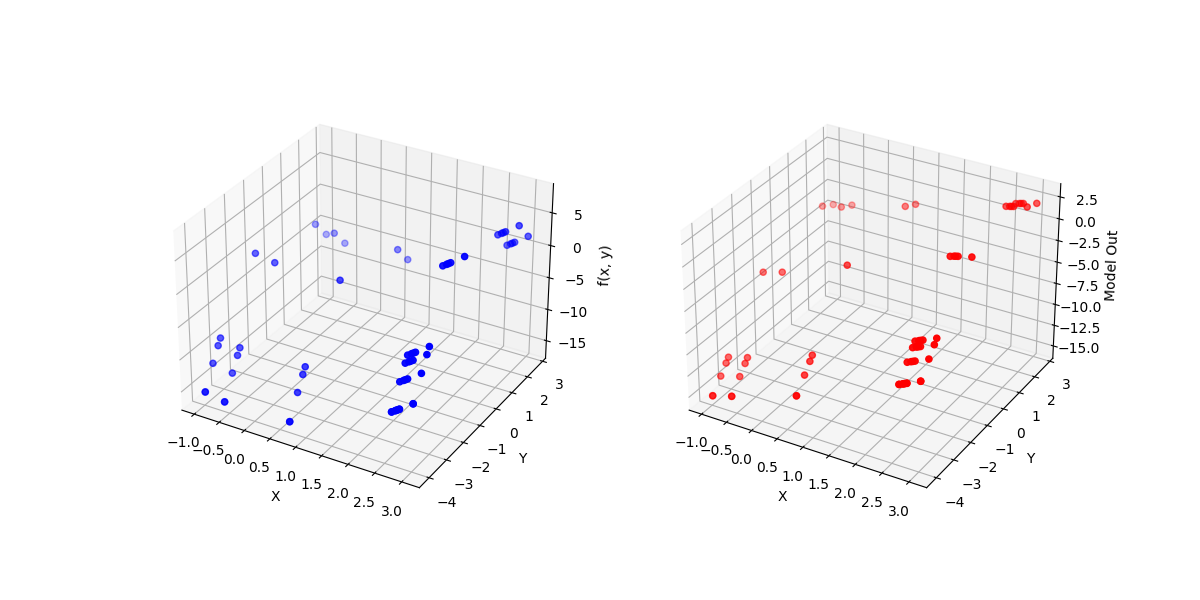

In [105]:
# Gather all Data
sample_x, sample_y, sample_z, sample_out = [], [], [], []
for sample, target in loader:
    sample, target = sample.to(device), target.to(device)
    out = model(sample)

    sample = sample.cpu().detach().numpy()
    target = target.cpu().detach().numpy()
    out = out.cpu().detach().numpy()

    sample_x.append(sample[:, 0])
    sample_y.append(sample[:, 1])
    sample_z.append(target)
    sample_out.append(out)

sample_x = np.concatenate(sample_x).reshape(8, 8)
sample_y = np.concatenate(sample_y).reshape(8, 8)
sample_z = np.concatenate(sample_z).reshape(8, 8)
sample_out = np.concatenate(sample_out).reshape(8, 8)

# Visualize
fig = plt.figure(figsize=(12, 6))
ax0 = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122, projection='3d')

ax0.scatter(sample_x, sample_y, sample_z, color='Blue')
ax1.scatter(sample_x, sample_y, sample_out, color='red')

ax0.set_xlabel('X')
ax0.set_ylabel('Y')
ax0.set_zlabel('f(x, y)')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Model Out')

plt.show()

# 🏘️A real-world example (Image Classification)

Assume all the folders are in directories with the following format:
```
.
└── flower_photos/
    ├── train/
    │   ├── sunflower/
    │   │   ├── 8480886751_71d88bfdc0_n.jpg
    │   │   └── 8481979626_98c9f88848_n.jpg
    │   ├── daisy
    │   ├── dandelion
    │   ├── roses
    │   └── tulips
    ├── validation/
    │   ├── sunflower
    │   ├── daisy
    │   ├── dandelion
    │   ├── roses
    │   └── tulips
    └── test/
        ├── sunflower
        ├── daisy
        ├── dandelion
        ├── roses
        └── tulips
```

In [106]:
from torchvision import datasets, transforms
# (H, W, C =3) -> (C, H, W)
# [0, 255] -> [0, 1]

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ]) # it's just an example to take 0.5. But normalization is necesary


TRAIN_DATA_PATH = "/content/drive/MyDrive/flower_photos/train"
TEST_DATA_PATH = "/content/drive/MyDrive/flower_photos/test"

trainset = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

plt.close('all')
plt.imshow(trainset[0][0].permute(1, 2, 0))
plt.show()
print("Image label:", trainset.classes[trainset[0][1]])

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/flower_photos/train'

For this tutorial, however, we use an easier dataset called FashionMNIST.

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/FashionMNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data/FashionMNIST_data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


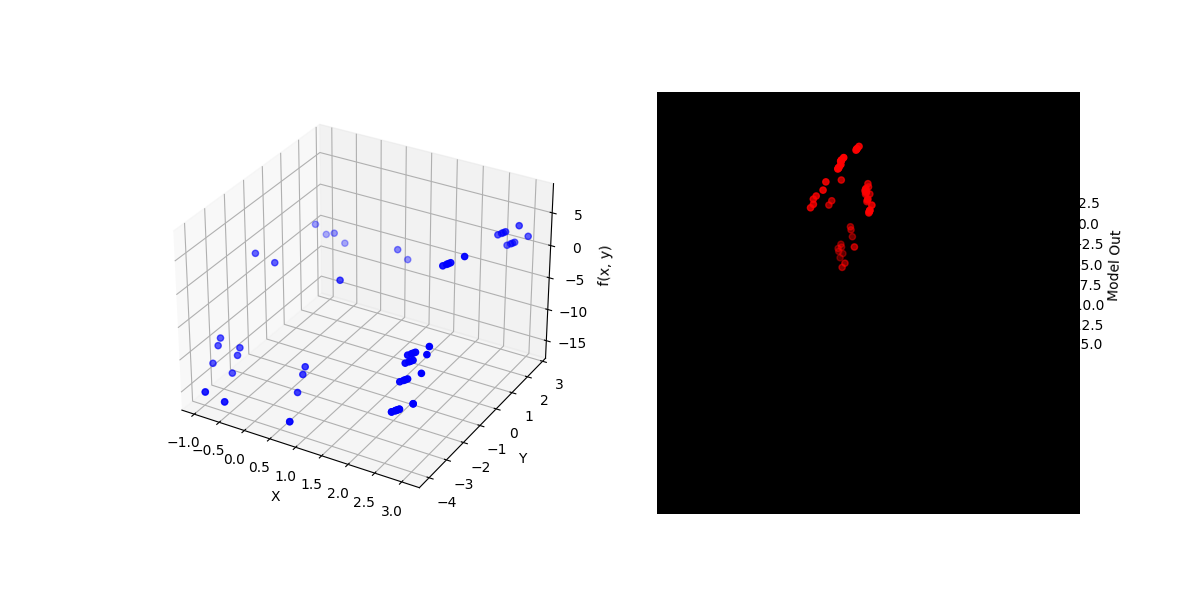

Label: Pullover


In [108]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.FashionMNIST('./data/FashionMNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('./data/FashionMNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

print(trainset)
print(testset)

# Display image and label.
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[1].squeeze()
label = train_labels[1]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {trainset.classes[label]}")

In [109]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.hidden = nn.Linear(784, 256)
        self.output = nn.Linear(256, 10)

        self.sigmoid = nn.Sigmoid()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.log_softmax(x)

        return x

model = Network()
print(model)

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (log_softmax): LogSoftmax(dim=1)
)


### Training with CPU

**wandb:** It's a cloud-based logging system that you can use to monitor your training. Visit https://wandb.ai to create a user.

In [110]:
!pip install -q wandb
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [111]:
n_epochs = 5
lr = 0.003

model = Network()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

wandb.init(project='FashionMNIST',
           name='run-with-CPU',
           config={
               'learning_rate': lr,
               'epochs': n_epochs,
           })

# Training
for epoch in range(n_epochs):
    epoch_loss = 0
    for i, (images, labels) in tqdm(enumerate(trainloader), total=len(trainloader)):
        images = images.view(images.shape[0], -1)

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss = epoch_loss / len(trainloader)
    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss}")

    wandb.log({'loss': epoch_loss})

# Evaluation
with torch.no_grad():
    accuracy = 0

    for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)

        # get the predictions: argmax etc.
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

    accuracy = accuracy / len(testloader)
    print(f"Test Accuracy: {accuracy:.3f}")

    wandb.summary["final_accuracy"] = accuracy


# Log test images, model pred, and ground truth as a table
table_data = []

max_log = 100
for idx, (image, label) in enumerate(testset):
    if idx == max_log:
        break

    wandb_img = wandb.Image(image)
    log_ps = model(image.view(1, -1))
    ps = torch.exp(log_ps)
    top_p, top_class = ps.topk(1, dim=1)

    table_data.append(
        [wandb_img, testset.classes[top_class.item()], testset.classes[label]]
    )

columns = ["image", "prediction", "truth"]
test_table = wandb.Table(data=table_data, columns=columns)
wandb.log({"test_images": test_table})

wandb.finish()

100%|██████████| 938/938 [00:18<00:00, 51.09it/s]


Epoch 1/5, Loss: 1.9478831255613869


100%|██████████| 938/938 [00:17<00:00, 54.71it/s]


Epoch 2/5, Loss: 1.3903985693256484


100%|██████████| 938/938 [00:16<00:00, 55.39it/s]


Epoch 3/5, Loss: 1.109801364288147


100%|██████████| 938/938 [00:16<00:00, 58.18it/s]


Epoch 4/5, Loss: 0.9564389872398458


100%|██████████| 938/938 [00:17<00:00, 53.75it/s]


Epoch 5/5, Loss: 0.8606788449958443
Test Accuracy: 0.729


loss,█▄▃▂▁
final_accuracy,0.7285
loss,0.86068


### Training with GPU

In [112]:
n_epochs = 5
lr = 0.003

model = Network()
model.cuda()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

wandb.init(project='FashionMNIST',
           name='run-with-GPU',
           config={
               'learning_rate': lr,
               'epochs': n_epochs,
           })

# Training
n_epochs = 5
for epoch in range(n_epochs):
    epoch_loss = 0
    for i, (images, labels) in tqdm(enumerate(trainloader), total=len(trainloader)):
        images, labels = images.cuda(), labels.cuda()
        images = images.view(images.shape[0], -1)

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss = epoch_loss / len(trainloader)
    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss}")

    wandb.log({'loss': epoch_loss})

# Evaluation
with torch.no_grad():
    accuracy = 0

    for images, labels in testloader:
        images, labels = images.cuda(), labels.cuda()
        images = images.view(images.shape[0], -1)
        log_ps = model(images)

        # get the predictions: argmax etc.
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

    accuracy = accuracy / len(testloader)
    print(f"Test Accuracy: {accuracy:.3f}")

    wandb.summary["final_accuracy"] = accuracy

wandb.finish()

100%|██████████| 938/938 [00:16<00:00, 56.10it/s]


Epoch 1/5, Loss: 1.9786105138152392


100%|██████████| 938/938 [00:15<00:00, 60.99it/s]


Epoch 2/5, Loss: 1.4153446054407783


100%|██████████| 938/938 [00:17<00:00, 54.31it/s]


Epoch 3/5, Loss: 1.1198949254016632


100%|██████████| 938/938 [00:16<00:00, 57.19it/s]


Epoch 4/5, Loss: 0.9606088300757825


100%|██████████| 938/938 [00:15<00:00, 61.29it/s]


Epoch 5/5, Loss: 0.8620578255226363
Test Accuracy: 0.730


loss,█▄▃▂▁
final_accuracy,0.7297
loss,0.86206
